In [ ]:
#cargar paquetes de Spark
!pip install pyspark[sql]

from __future__ import print_function
from functools import wraps
import pyspark as spark 
from pyspark import SparkConf
import time
from operator import add
import os 
from subprocess import STDOUT, check_call, check_output

     |████████████████████████████████| 212.3MB 64kB/s 
     |████████████████████████████████| 204kB 19.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=b0cf9a057f6e8d5da171c3865886cc47fb9019c165f5085ead7d5fbd39b0f860
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.stats as ss
import seaborn as sbn
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from mlxtend.plotting import plot_learning_curves
from sklearn.utils import resample

# Configuración Spark y Google Collab

In [ ]:
#configurar entorno de spark
def set_conf():
    conf = SparkConf().setAppName("App")
    conf = (conf.setMaster('local[*]')
      .set('spark.executor.memory', '4G')
      .set('spark.driver.memory', '16G')
      .set('spark.driver.maxResultSize', '8G'))
    return conf

In [ ]:
#definir spark context
sc = spark.SparkContext.getOrCreate(conf=set_conf())

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
Spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Presentación del problema

Este conjunto de datos contiene **563201 muestras con diferentes variables médicas relativas a la enfermedad del Covid-19**. El objetivo que queremos alcanzar, por medio de diversas mediciones, será por un lado predecir si un paciente tendrá mal pronóstico (y con ello nos referimos a si muere o es ingresado en uci) y por otro lado identificar aquellas características más relevantes que indican este mal pronóstico final. Los datos pertenecen a una base de datos exraida de la plataforma *Kaggle*, la BD en cuestión recoge registros asociados a pacientes COVID publicados por el Gobierno de México durante los primeros meses de pandemia. Se trata de un archivo *Excel* que contiene 23 características que mostraremos a continuación (así como la naturaleza de estas):

    *    Sex: Identifica al sexo del paciente.
    *    patient_type: Identifica el tipo de atención que recibió el paciente en la unidad
    *    entry_date: Identifica la fecha de ingreso del paciente a la unidad de atención.
    *    date_symptoms: Idenitifica la fecha en que inició la sintomatología del paciente.
    *    date_died: Identifica la fecha en que el paciente falleció.
    *	Intubed: Identifica si el paciente requirió de intubación
    *	Pneumonia: Identifica si al paciente se le diagnosticó con neumonía.
    *	Age: Identifica la edad del paciente.
    *	Pregnancy: Identifica si la paciente está embarazada
    *	Diabetes: Identifica si el paciente tiene un diagnóstico de diabetes.
    *	Copd: Identifica si el paciente tiene un diagnóstico de EPOC.
    *	Asthma: Identifica si el paciente tiene un diagnóstico de asma.
    *	Inmsupr: Identifica si el paciente presenta inmunosupresión. 
    *	Hypertension: Identifica si el paciente tiene un diagnóstico de hipertensión.
    *	other_disease: Identifica si el paciente tiene diagnóstico de otras enfermedades.
    *	cardiovascular: Identifica si el paciente tiene un diagnóstico de enfermedades cardiovasculares.
    *	obesity: Identifica si el paciente tiene diagnóstico de obesidad.
    *	renal_chronic: Identifica si el paciente tiene diagnóstico de insuficiencia renal crónica.
    *	tobacco: Identifica si el paciente tiene hábito de tabaquismo.
    *	contact_other_covid: Identifica si el paciente tuvo contacto con algún otro caso diagnósticado con SARS CoV-2
    *	covid_res: Identifica si el paciente tuvo contacto con algún otro caso diagnósticado con SARS CoV-2 
    *	icu: Identifica si el paciente requirió ingresar a una Unidad de Cuidados Intensivos.

# Análisis descriptivo de los datos

In [ ]:
data= Spark.read.csv("/content/drive/MyDrive/PMD-grupo/PROYECTO/covid.csv", header=True)
#data= Spark.read.csv("/content/covid.csv", header=True)

In [ ]:
# Representación 5 primeros registros
data.show(5)

+------+---+------------+----------+-------------+----------+-------+---------+---+---------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-------------------+---------+---+
|    id|sex|patient_type|entry_date|date_symptoms| date_died|intubed|pneumonia|age|pregnancy|diabetes|copd|asthma|inmsupr|hypertension|other_disease|cardiovascular|obesity|renal_chronic|tobacco|contact_other_covid|covid_res|icu|
+------+---+------------+----------+-------------+----------+-------+---------+---+---------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-------------------+---------+---+
|16169f|  2|           1|04-05-2020|   02-05-2020|9999-99-99|     97|        2| 27|       97|       2|   2|     2|      2|           2|            2|             2|      2|            2|      2|                  2|        1| 97|
|1009bf|  2|           1|19-03-2020|   17-03-2020|9999-99-99|     97|        2| 24| 

In [ ]:
# Breve descripción por medio de estadísticos del dataset
data.describe().show()

+-------+--------+-------------------+-------------------+----------+-------------+----------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+----------------+-------------------+------------------+-----------------+
|summary|      id|                sex|       patient_type|entry_date|date_symptoms| date_died|          intubed|         pneumonia|               age|         pregnancy|          diabetes|             copd|            asthma|           inmsupr|      hypertension|     other_disease|   cardiovascular|           obesity|     renal_chronic|         tobacco|contact_other_covid|         covid_res|              icu|
+-------+--------+-------------------+-------------------+----------+-------------+----------+-----------------+------------------+------------------+------------------+-----


## Preprocesado de los datos

En esta etapa, realizando un análisis exploratorio del dataset, llegamos a la conclusión de que lo ideal para conseguir buenas mediciones y una eficiente y correcta aplicación de los algoritmos *machine learning* escogidos sería **eliminar algunas de las variables**. ¿Por qué? Por dos razones de peso: por un lado porque consideramos que no aportan información relevante para el objetivo final del proyecto y con esto nos referimos a las variables *id*, *contact_other_covid* e *intubed* y por otro lado, porque algunas de las columnas del archivo contienen demasiado valores nulos (*pregnancy* y *data_died*)

En cuanto a los *missing values*, en la base de datos los valores nulos pueden tomar los valores 97, 98, 99 y 99-99-9999 (cuando se tratan de fechas). Los reemplazaremos por *None* para posteriormente eliminar las filas que contienen alguno de estos valores. Además seleccionaremos sólo aquellos registros cuyos pacientes hayan dado positivo en el test Covid-19, ya que nos queremos asegurar de analizar sólo a pacientes que presenten la enfermedad. 

Además crearemos una nueva variable combinando las variables *date_died* e *icu* que se llamará *icu_or_died*. Esta variable representa el mal pronóstico del paciente, que es lo que queremos predecir.

In [ ]:
#caracterizamos todos los missing values como "None"
data=data.replace("99", None)
data=data.replace("98", None)
data=data.replace("97", None)
data=data.replace("9999-99-99" , None)

In [ ]:
#missing values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+---+------------+----------+-------------+---------+-------+---------+---+---------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-------------------+---------+------+
| id|sex|patient_type|entry_date|date_symptoms|date_died|intubed|pneumonia|age|pregnancy|diabetes|copd|asthma|inmsupr|hypertension|other_disease|cardiovascular|obesity|renal_chronic|tobacco|contact_other_covid|covid_res|   icu|
+---+---+------------+----------+-------------+---------+-------+---------+---+---------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-------------------+---------+------+
|  3|  0|           0|         0|            0|   530426| 444813|       11|207|   288699|    1981|1749|  1752|   1980|        1824|         2598|          1822|   1781|         1792|   1907|             175031|        0|444814|
+---+---+------------+----------+-------------+---------+-------+---------+---+---------

In [ ]:
#seleccionamos solo los pacientes que han sido diagnosticados como positivos en COVID
data=data.filter(data.covid_res==1)

In [ ]:
#creamos una columna para almacenar la información de si un paciente ha muerto, ha sido ingresado en uci, o ambas
from pyspark.sql.functions import when
icu_or_died=when(
    col("date_died").isNotNull() | (col("icu")==1), 1
).otherwise(2)

In [ ]:
data=data.withColumn("icu_or_died", icu_or_died)

In [ ]:
data.show(20)

+--------+---+------------+----------+-------------+----------+-------+---------+---+---------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-------------------+---------+----+-----------+
|      id|sex|patient_type|entry_date|date_symptoms| date_died|intubed|pneumonia|age|pregnancy|diabetes|copd|asthma|inmsupr|hypertension|other_disease|cardiovascular|obesity|renal_chronic|tobacco|contact_other_covid|covid_res| icu|icu_or_died|
+--------+---+------------+----------+-------------+----------+-------+---------+---+---------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-------------------+---------+----+-----------+
|  16169f|  2|           1|04-05-2020|   02-05-2020|      null|   null|        2| 27|     null|       2|   2|     2|      2|           2|            2|             2|      2|            2|      2|                  2|        1|null|          2|
|  1009bf|  2|          

In [ ]:
#eliminamos las columnas "id", "contact_other_covid","pregnancy", "intubed", "date_died"
data=data.drop("id","contact_other_covid", "pregnancy", "intubed", "date_died", "icu")

# Subsampling, train y test y creación de nueva variable

En este apartado realizamos tres tareas fundamentales:
- **Subsampling**: al tener clases bastante desbalanceadas aplicamos esta técnica para balancearlas. Hay bastantes más observaciones con etiqueta 1 en la variable que queremos predecir en nuestra base de datos. Para resolver esto, hacemos que la clase mayoritaria tenga mismo número de observaciones que la clase minoritaria.
- **Train y test**: división de los datos en conjunto de entrenamiento y evaluación. Realizamos algunos ajustes para posteriormente implementar los modelos sin errores. Además, no utilizaremos todas las variables, sino las que creemos que pueden resultar útil para llegar a nuestro objetivo final.
- **Creación de nueva variable**: se trata de la suma de las patologías previas asociadas al paciente, variable que creemos que puede ser importante en el mal pronóstico final de este: *n_total_diseases*.

In [ ]:
#seleccionamos las columnas que usaremos
data=data.select("sex","pneumonia","age","diabetes","copd","asthma","inmsupr","hypertension", "cardiovascular", "obesity", "renal_chronic", "tobacco", 'other_disease', "icu_or_died")
data=data.dropna()

In [ ]:
#paso a pandas (dataframe)
df_uci= data.filter(data.icu_or_died==1).toPandas()
df_nouci= (data.filter(data.icu_or_died==2)).toPandas()

In [ ]:
#cambio de valor a tipo int
df_uci = df_uci.astype(int)
df_nouci = df_nouci.astype(int)

In [ ]:
#realizamos el subsampling
df_nouci_resampled = resample(df_nouci, replace=False, n_samples=len(df_uci), random_state=123)
data_resampled=pd.concat([df_nouci_resampled,df_uci])

In [ ]:
#cambiamos los 2 por 0 para facilitarnos la creacion de la nueva variable
data_resampled= data_resampled.replace({2: 0})

In [ ]:
# Creamos una nueva variable que será el numero total de patologias asociadas al paciente: "n_total_diseases"
col_list= ["diabetes","copd","asthma","inmsupr","hypertension", "cardiovascular", "obesity", "renal_chronic", "other_disease"]
data_resampled["n_total_diseases"] = data_resampled[col_list].sum(axis=1)
data_resampled

,sex,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,other_disease,icu_or_died,n_total_diseases
109698,0,0,41,0,0,0,0,0,0,1,0,0,0,0,1
67008,1,0,34,0,0,0,0,0,0,0,0,0,0,0,0
154666,1,0,38,0,0,0,0,0,0,0,0,0,0,0,0
63356,1,0,57,1,0,0,0,0,0,0,0,0,0,0,1
187228,1,0,49,1,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29439,1,0,59,1,0,0,0,1,0,1,0,0,0,1,3
29440,0,1,66,1,0,0,0,0,0,0,0,0,0,1,1
29441,0,1,58,0,0,0,0,0,0,0,0,0,0,1,0
29442,0,1,65,1,0,0,0,1,0,1,0,0,0,1,3


In [ ]:
#dividimos en x e y
X=data_resampled.drop("icu_or_died",axis=1)
Y=data_resampled["icu_or_died"]

In [ ]:
# train y test
X_train, X_test, Y_train, Y_test= train_test_split(X,Y,test_size=0.25,stratify=Y)

In [ ]:
x=0
for k in (X_train.columns):
  print(x, k)
  x+=1

0 sex
1 pneumonia
2 age
3 diabetes
4 copd
5 asthma
6 inmsupr
7 hypertension
8 cardiovascular
9 obesity
10 renal_chronic
11 tobacco
12 other_disease
13 n_total_diseases


# Implementación de modelos

## Árbol de decisión

In [ ]:
max_depth = np.arange(1, 16)
min_samples_leaf = [50, 100, 200]

# GridSearchCV para buscar los mejores parámetros
param_grid = { 'criterion':['gini','entropy'],'max_depth': max_depth}

# Creamos un árbol de clasificación
dtree_model=tree.DecisionTreeClassifier()

# Usamos gridsearch para evluar los parámetros
dtree_model = GridSearchCV(dtree_model, param_grid, cv=3, scoring= "balanced_accuracy", return_train_score=True)

# 
dtree_model=dtree_model.fit(X_train, Y_train)
print(dtree_model.best_params_)

{'criterion': 'entropy', 'max_depth': 7}


In [ ]:
#EVALUAMOS
my_model = dtree_model.best_estimator_
my_tree=my_model.fit(X_train, Y_train)
#Predeccimos usando X_test
y_predicted = my_model.predict(X_test)
# Resultados
print(accuracy_score(Y_test, y_predicted))
print(confusion_matrix(Y_test, y_predicted))



0.8276728705338948
[[5747 1614]
 [ 923 6438]]


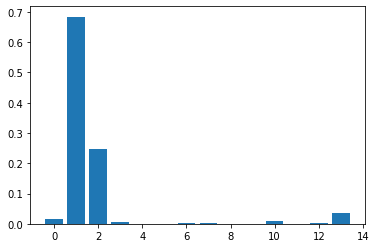

In [ ]:
#importancia de caracteisticas
from matplotlib import pyplot
importance=my_tree.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

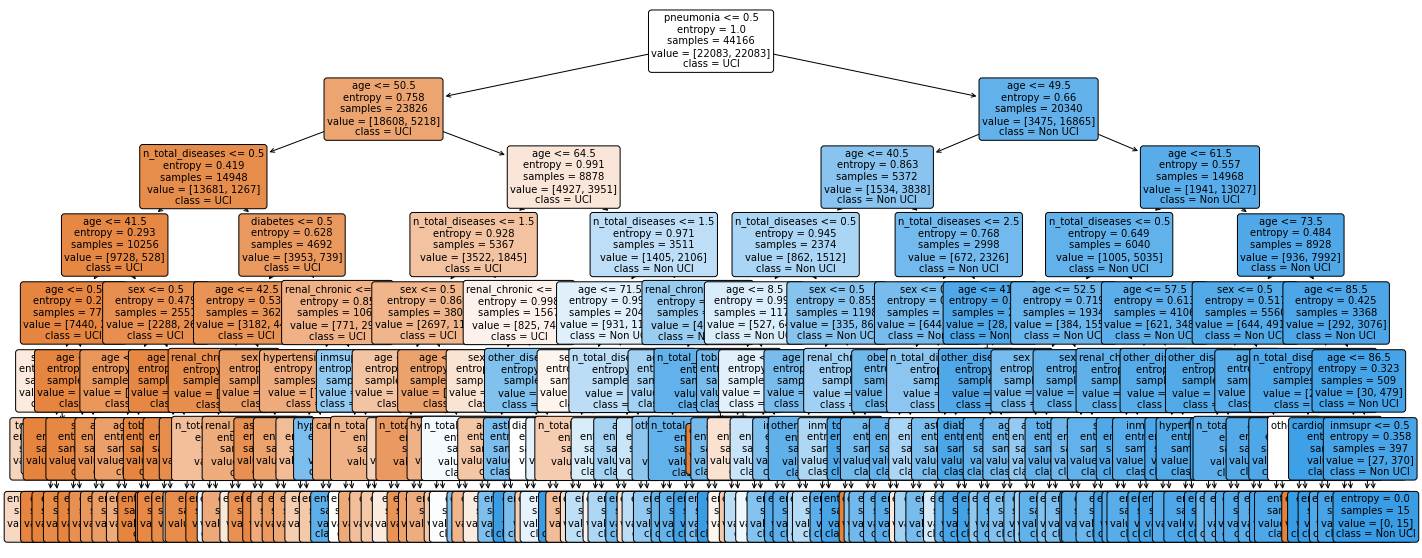

In [ ]:
#figura árbol
plt.figure(figsize=(24,10))
sklearn.tree.plot_tree(my_tree, max_depth=dtree_model.best_params_['max_depth'],feature_names = X.columns,
                       class_names=['UCI','Non UCI'], filled=True, rounded= True, fontsize=10)
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# GridSearchCV para buscar los mejores parámetros
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}

# RandomForest
forest_model = RandomForestClassifier(n_estimators=10)

# Usamos gridsearch para evluar los parámetros
forest_model = GridSearchCV(forest_model, param_grid, cv=3, scoring= "balanced_accuracy", return_train_score=True)

# 
forest_model=forest_model.fit(X_train, Y_train)
print(forest_model.best_params_)

{'criterion': 'gini', 'max_depth': 8}


In [ ]:
#EVALUAMOS
mymodel = forest_model.best_estimator_
my_forest=mymodel.fit(X_train, Y_train)
#Predeccimos usando X_test
y_predicted = mymodel.predict(X_test)
# Resultados
print(accuracy_score(Y_test, y_predicted))
print(confusion_matrix(Y_test, y_predicted))

0.8278766471946747
[[5717 1644]
 [ 890 6471]]


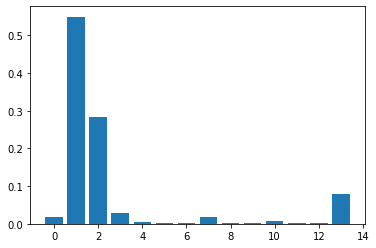

In [ ]:
#importancia de caracteristicas
from matplotlib import pyplot
importance=mymodel.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## GBM

### XGBoost

In [ ]:
# XGBoost
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import classification_report


# Parameter Tuning
model_xgbm = xgb.XGBClassifier()
param_dist = {"max_depth": [30,50],
              "min_child_weight" : [6,9],
              "n_estimators": [200],
              "learning_rate": [ 0.11,0.16 ],}
grid_search = GridSearchCV(model_xgbm, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train, Y_train)

print(grid_search.best_estimator_)
model_xgbm = grid_search.best_estimator_

model_xgbm.fit(X_train,Y_train)



Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  6.9min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.11, max_delta_step=0, max_depth=30,
              min_child_weight=9, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.11, max_delta_step=0, max_depth=30,
              min_child_weight=9, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_predicted = model_xgbm.predict(X_test)

print("Accuracy:" , accuracy_score(Y_test, y_predicted),"\n", "ConfusionMatrix:" ,"\n", confusion_matrix(Y_test, y_predicted))

Accuracy: 0.8217633473712811 
 ConfusionMatrix: 
 [[5813 1548]
 [1076 6285]]


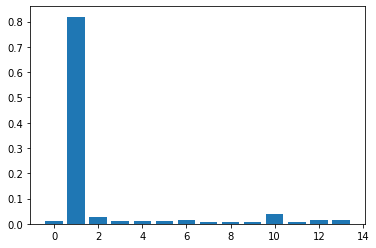

In [ ]:
#Importancia de carcteristicas en xgboost
pyplot.bar(range(len(model_xgbm.feature_importances_)), model_xgbm.feature_importances_)
pyplot.show()

### LightGBM

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import  roc_auc_score

In [ ]:
#LightGBM
import lightgbm as lgb
from sklearn import metrics

lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [10,25,50],
              "learning_rate" : [0.01,0.05],
              "num_leaves": [150,300,900],
              "n_estimators": [100,200]
             }

grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="balanced_accuracy", verbose=5)
grid_search.fit(X_train,Y_train)

lgb_model=grid_search.best_estimator_
lgb_model.fit(X_train,Y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.2min finished


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=150, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#evaluamos
y_predicted = lgb_model.predict(X_test)


print("Accuracy:" , accuracy_score(Y_test, y_predicted),"\n", "ConfusionMatrix:" ,"\n", confusion_matrix(Y_test, y_predicted))
print(classification_report(Y_test, y_predicted))

Accuracy: 0.8299144138024724 
 ConfusionMatrix: 
 [[5821 1540]
 [ 964 6397]]
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      7361
           1       0.81      0.87      0.84      7361

    accuracy                           0.83     14722
   macro avg       0.83      0.83      0.83     14722
weighted avg       0.83      0.83      0.83     14722



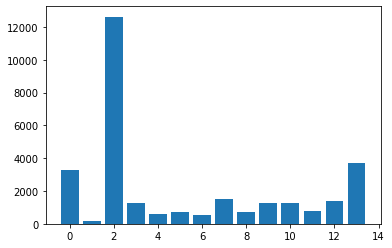

In [ ]:
# Importancia caracteristicas lgb
pyplot.bar(range(len(lgb_model.feature_importances_)), lgb_model.feature_importances_)
pyplot.show()

### Catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 71kB/s 


In [ ]:
# CatBoost
import catboost as cb

params = {'depth': [7, 10],
          'learning_rate' : [0.03, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [200]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(X_train, Y_train)

print(cb_model.best_estimator_)
clf = cb_model.best_estimator_

clf.fit(X_train,Y_train)


Se han truncado las últimas 5000 líneas del flujo de salida.
1:	learn: 0.6546340	total: 20.8ms	remaining: 2.06s
2:	learn: 0.6383022	total: 29.8ms	remaining: 1.96s
3:	learn: 0.6225064	total: 40.7ms	remaining: 2s
4:	learn: 0.6071847	total: 50.9ms	remaining: 1.99s
5:	learn: 0.5933823	total: 61.7ms	remaining: 1.99s
6:	learn: 0.5812119	total: 71.9ms	remaining: 1.98s
7:	learn: 0.5690601	total: 82.4ms	remaining: 1.98s
8:	learn: 0.5581467	total: 92.9ms	remaining: 1.97s
9:	learn: 0.5474942	total: 106ms	remaining: 2.01s
10:	learn: 0.5385636	total: 120ms	remaining: 2.06s
11:	learn: 0.5293485	total: 131ms	remaining: 2.04s
12:	learn: 0.5209110	total: 141ms	remaining: 2.03s
13:	learn: 0.5135174	total: 152ms	remaining: 2.01s
14:	learn: 0.5069928	total: 163ms	remaining: 2.01s
15:	learn: 0.5003420	total: 174ms	remaining: 2s
16:	learn: 0.4939150	total: 185ms	remaining: 1.99s
17:	learn: 0.4884349	total: 192ms	remaining: 1.94s
18:	learn: 0.4836617	total: 202ms	remaining: 1.92s
19:	learn: 0.4783772	total: 

In [ ]:
y_predict = clf.predict(X_test)

print("Accuracy:" , accuracy_score(Y_test, y_predict),"\n", "ConfusionMatrix:" ,"\n", confusion_matrix(Y_test, y_predict))

Accuracy: 0.8307974459991849 
 ConfusionMatrix: 
 [[5822 1539]
 [ 952 6409]]


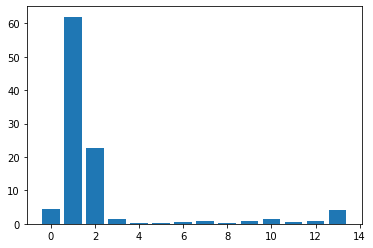

In [ ]:
# Importancia de características en catboost
from matplotlib import pyplot
imp=clf.get_feature_importance(type='PredictionValuesChange') 
pyplot.bar([x for x in range(len(imp))], imp)
pyplot.show()
